In [1]:
!pip install split-folders

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import kagglehub
import os
import random
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#parameters
#classes
max_classes_num = 130
classes_num = 5

#images
img_size = (224,224)
batch_size = 32

#model
epochs_num = 25

In [4]:
download_dir = kagglehub.dataset_download("thedevastator/anime-face-dataset-by-character-name")
input_dir = "/kaggle/modifiedInput/AnimeFaceRecognition"
output_dir = "/kaggle/output/AnimeFaceRecognition"
dataset_source_dir = os.path.join(download_dir, "dataset")

if os.path.exists(dataset_source_dir):
  print(f"Dataset downloaded successfully in {dataset_source_dir}")

  os.makedirs(input_dir, exist_ok=True)
  dataset_target_dir = os.path.join(input_dir, "dataset")
  os.makedirs(dataset_target_dir, exist_ok=True)

  all_classes = os.listdir(dataset_source_dir)
  selected_classes = random.sample(all_classes, classes_num % max_classes_num)

  for class_name in selected_classes:
    class_source_dir = os.path.join(dataset_source_dir, class_name)
    class_target_dir = os.path.join(dataset_target_dir, class_name)

    shutil.copytree(class_source_dir, class_target_dir)
    print(f"Copied {class_name} class")

  print("Dataset copied successfully")

  split_ratio = (0.8, 0.1, 0.1)

  splitfolders.ratio(
      dataset_target_dir,
      output=output_dir,
      seed=500,
      ratio=split_ratio,
      group_prefix=None
  )
else:
  print("Dataset download failed.")

100%|██████████| 57.9M/57.9M [00:00<00:00, 77.0MB/s]

Extracting files...


Dataset downloaded successfully in /root/.cache/kagglehub/datasets/thedevastator/anime-face-dataset-by-character-name/versions/1/dataset
Copied mash_kyrielight class
Copied shishiro_botan class
Copied lancer class
Copied souryuu_asuka_langley class
Copied zero_two_(darling_in_the_franxx) class
Dataset copied successfully


Copying files: 375 files [00:00, 2892.27 files/s]


In [5]:
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

In [6]:
#Data augmentation for test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#Data augmentation form validation data
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
valid_dir = os.path.join(output_dir, "val")

train_data = train_datagen.flow_from_directory(
  train_dir,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
  test_dir,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
  valid_dir,
  target_size=img_size,
  batch_size=batch_size,
  class_mode='categorical'
)

Found 300 images belonging to 5 classes.
Found 40 images belonging to 5 classes.
Found 35 images belonging to 5 classes.


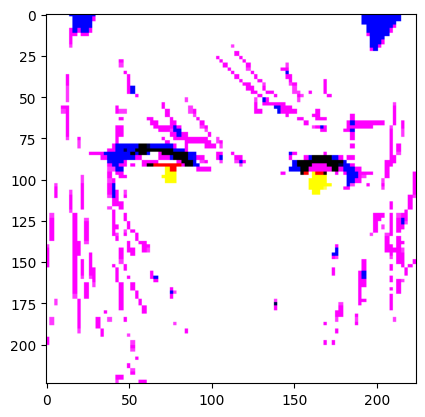

In [8]:
#batch of images and labels
images, labels = next(valid_data)

#select a random image from the batch
idx = np.random.randint(0, images.shape[0] - 1)

plt.imshow(images[idx])
plt.show()

In [9]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

#freeze the convolutional base
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_data, epochs=epochs_num, validation_data=valid_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step - accuracy: 0.2917 - loss: 2.1911 - val_accuracy: 0.6857 - val_loss: 0.8094
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.5801 - loss: 1.0170 - val_accuracy: 0.8857 - val_loss: 0.5140
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.7493 - loss: 0.7153 - val_accuracy: 0.9143 - val_loss: 0.3568
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.8445 - loss: 0.4902 - val_accuracy: 0.8857 - val_loss: 0.3494
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.7548 - loss: 0.5821 - val_accuracy: 0.8571 - val_loss: 0.3343
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.8722 - loss: 0.3883 - val_accuracy: 0.8857 - val_loss: 0.3451
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.8697 - loss: 0.4017 - val_accuracy: 0.8286 - val_loss: 0.3291
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 6s/step - accuracy: 0.9113 - loss: 0.2859 - val_accuracy: 0.8857 - val_loss:

In [13]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9563 - loss: 0.3382
Test accuracy: 95.00%


In [14]:
selected_classes.sort()

def predict_img(image, model):
  test_img = cv2.imread(image)
  test_img = cv2.resize(test_img, img_size)
  test_img = np.expand_dims(test_img, axis=0)
  result=model.predict(test_img)
  r=np.argmax(result)
  print(selected_classes[r])

In [15]:
#predict_img("/kaggle/output/AnimeFaceRecognition/test/shirogane_naoto/", model)

In [16]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def generate_confusion_matrix(model, test_data, class_names):
    # Get predictions
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = test_data.classes

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return cm, predicted_classes, true_classes

def generate_classification_report(true_classes, predicted_classes, class_names):
    report = classification_report(true_classes, predicted_classes,
                                 target_names=class_names, output_dict=True)

    # Convert to DataFrame for better visualization
    import pandas as pd
    df_report = pd.DataFrame(report).transpose()

    print("Classification Report:")
    print("=" * 60)
    print(df_report.round(3))

    return df_report

def visualize_predictions(model, test_data, class_names, num_images=9):
    # Get a batch of test images
    test_images, test_labels = next(test_data)
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)

    # Plot predictions
    plt.figure(figsize=(15, 15))
    for i in range(min(num_images, len(test_images))):
        plt.subplot(3, 3, i + 1)

        # Preprocess image for display
        img = test_images[i]
        if img.max() <= 1.0:
            img = (img * 255).astype('uint8')

        plt.imshow(img)

        # Determine color based on prediction correctness
        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        confidence = predictions[i][predicted_classes[i]] * 100

        plt.title(f'True: {class_names[true_classes[i]]}\n'
                 f'Pred: {class_names[predicted_classes[i]]}\n'
                 f'Conf: {confidence:.1f}%', color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Generating training history plots...


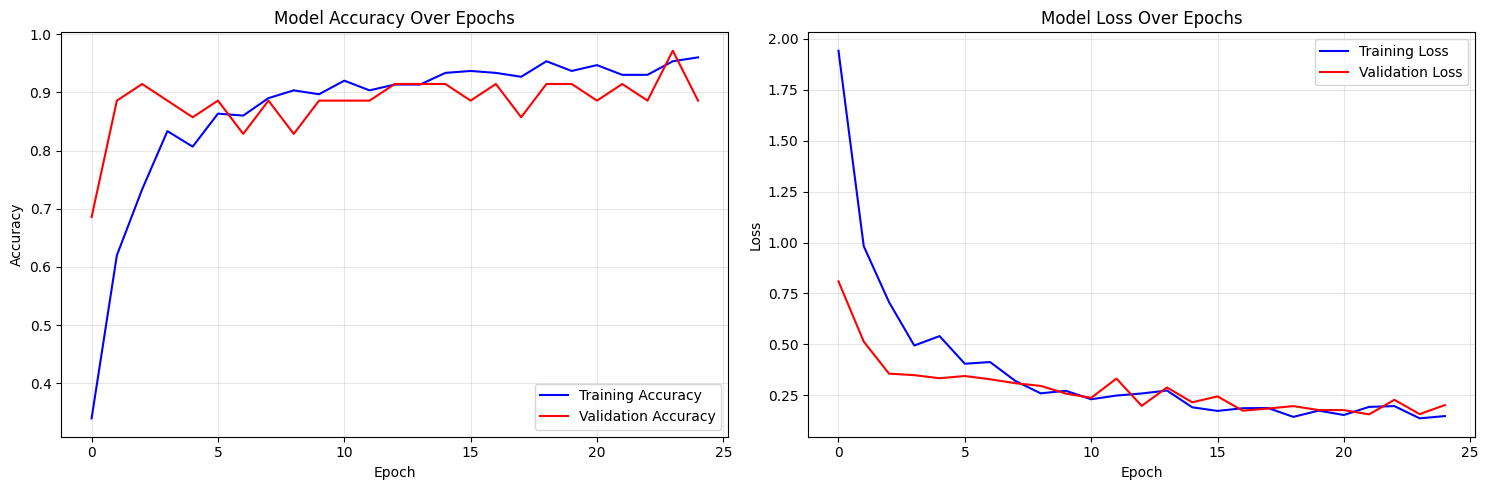


Generating confusion matrix...
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step


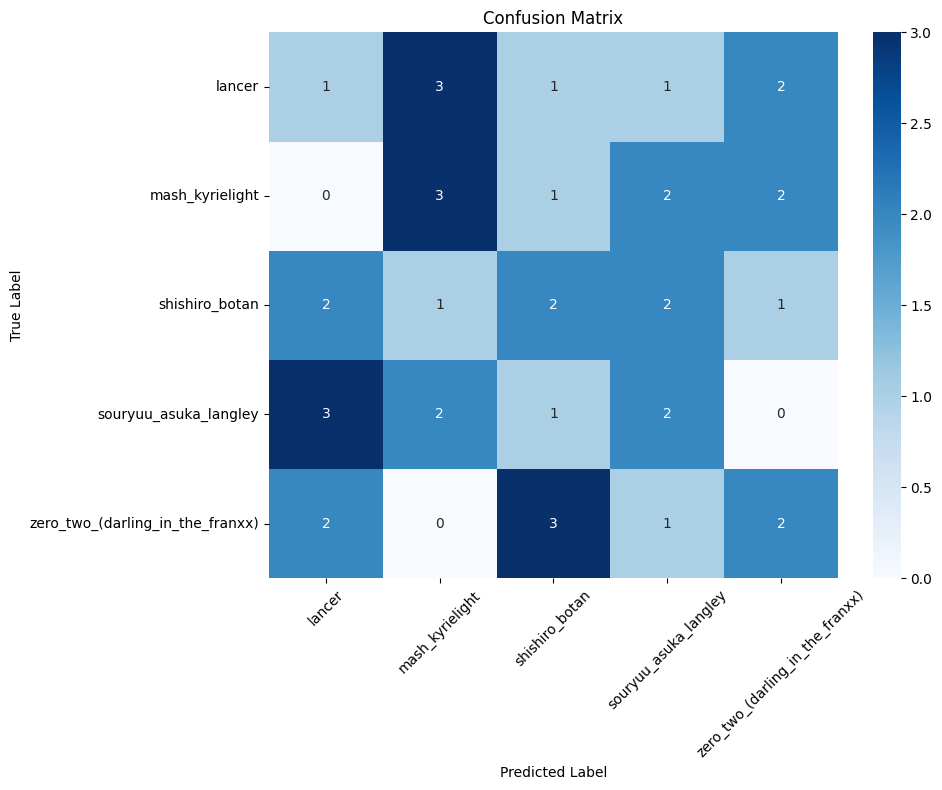


Generating classification report...
Classification Report:
                                  precision  recall  f1-score  support
lancer                                0.125   0.125     0.125     8.00
mash_kyrielight                       0.333   0.375     0.353     8.00
shishiro_botan                        0.250   0.250     0.250     8.00
souryuu_asuka_langley                 0.250   0.250     0.250     8.00
zero_two_(darling_in_the_franxx)      0.286   0.250     0.267     8.00
accuracy                              0.250   0.250     0.250     0.25
macro avg                             0.249   0.250     0.249    40.00
weighted avg                          0.249   0.250     0.249    40.00

Visualizing sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


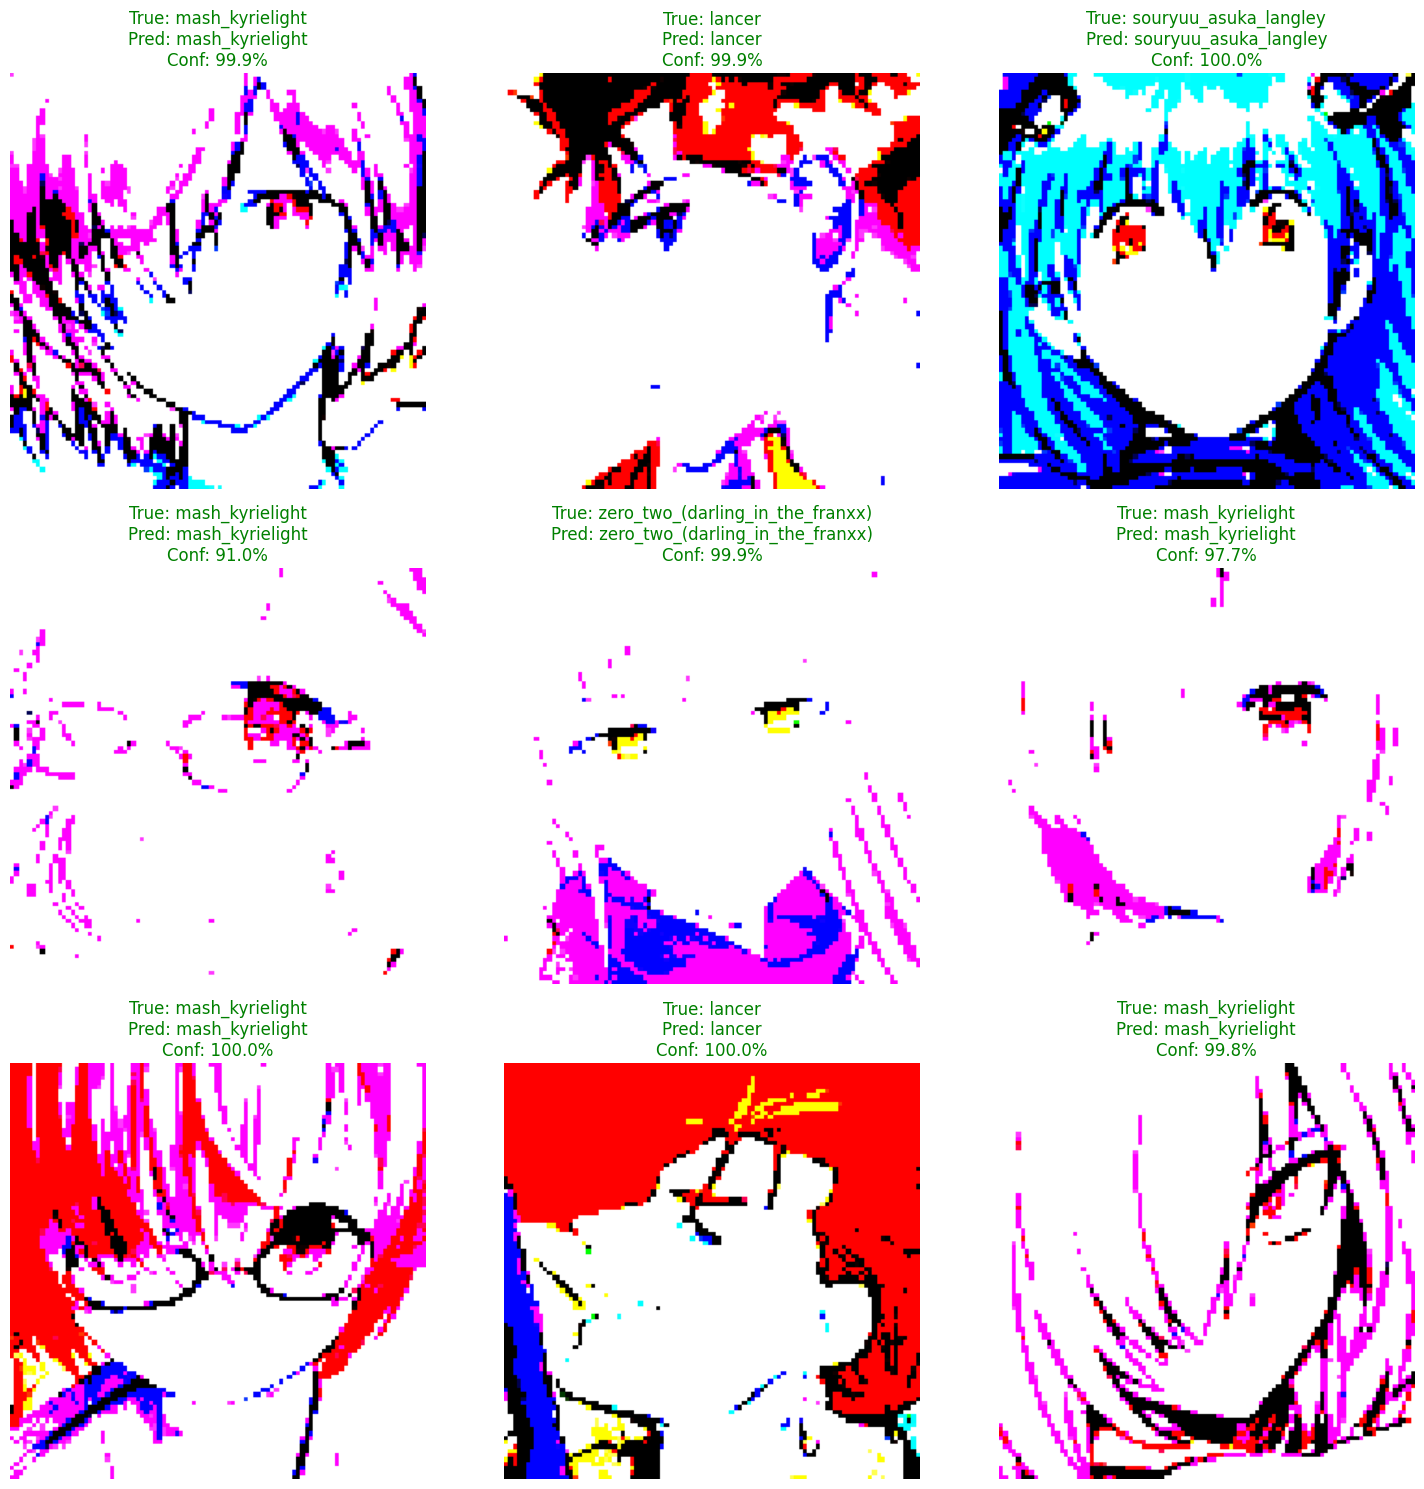


SUMMARY STATISTICS
Total test samples: 40
Number of classes: 5
Overall accuracy: 0.2500
lancer: 0.1250 (8 samples)
mash_kyrielight: 0.3750 (8 samples)
shishiro_botan: 0.2500 (8 samples)
souryuu_asuka_langley: 0.2500 (8 samples)
zero_two_(darling_in_the_franxx): 0.2500 (8 samples)


In [17]:
print("Generating training history plots...")
plot_training_history(history)

print("\nGenerating confusion matrix...")
cm, predicted_classes, true_classes = generate_confusion_matrix(model, test_data, selected_classes)

print("\nGenerating classification report...")
report_df = generate_classification_report(true_classes, predicted_classes, selected_classes)

print("\nVisualizing sample predictions...")
# Reset test_data generator
test_data.reset()
visualize_predictions(model, test_data, selected_classes, num_images=9)

# Additional metrics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Total test samples: {len(true_classes)}")
print(f"Number of classes: {len(selected_classes)}")
print(f"Overall accuracy: {(predicted_classes == true_classes).mean():.4f}")

# Per-class accuracy
for i, class_name in enumerate(selected_classes):
    class_mask = true_classes == i
    if class_mask.sum() > 0:
        class_accuracy = (predicted_classes[class_mask] == true_classes[class_mask]).mean()
        print(f"{class_name}: {class_accuracy:.4f} ({class_mask.sum()} samples)")

In [18]:
model.save("AnimeFaceRecognitionModel.keras")